# Check missing values

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("AB_NYC_2019.csv")

print("Missing Values:\n", df.isnull().sum())
print("\nBefore dropping missing names:", df.shape)
df = df.dropna(subset=["name", "host_name"])
print("After dropping missing names:", df.shape)


Missing Values:
 id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Before dropping missing names: (48895, 16)
After dropping missing names: (48858, 16)


Only 16 listings had missing names, and 21 had missing host names out of 48,895.

These were safely removed (only 37 rows dropped), resulting in a clean dataset of 48,858 rows.

This shows that the data is mostly complete and reliable, and only a very small portion needed removal.

# Check price distribution

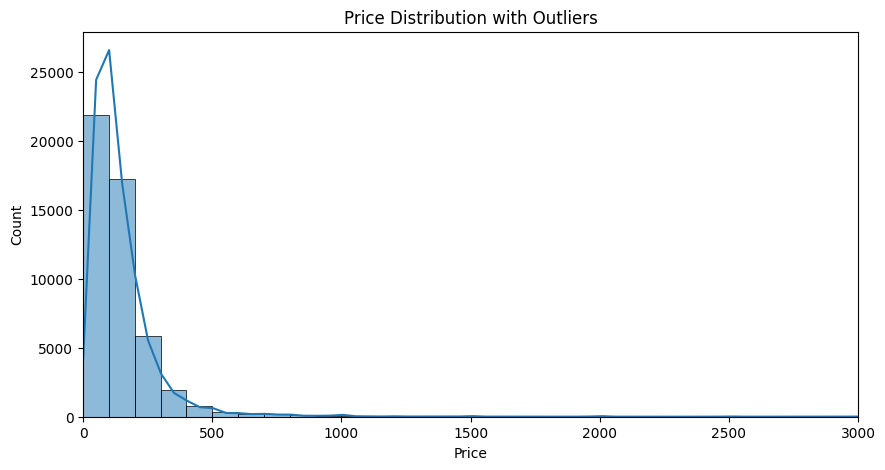

Listings with price = 0: 11
Listings with price > 1000: 239


In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution with Outliers")
plt.xlabel("Price")
plt.xlim(0, 3000)
plt.show()

# Reason: Prices like $0 or >$1000 are outliers (see plot), so we remove them
print("Listings with price = 0:", (df['price'] == 0).sum())
print("Listings with price > 1000:", (df['price'] > 1000).sum())
df = df[(df['price'] > 0) & (df['price'] < 1000)]

Only 11 listings had a price of $0, and 239 listings were priced over $1000.

By removing these 250 anomalies, we ensure that pricing insights are based on realistic and meaningful data.

The plot visually confirms a right-skewed distribution, where most listings are below $300, but a few extreme values exist.

# Check minimum_nights distribution

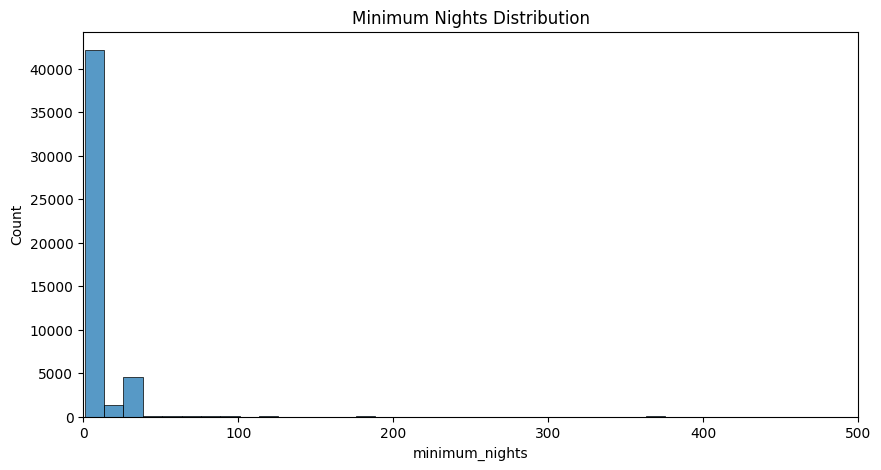

Max minimum_nights: 1250


In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df['minimum_nights'], bins=100)
plt.title("Minimum Nights Distribution")
plt.xlim(0, 500)
plt.show()

# Reason: Very long stays (e.g. 1000 nights) skew analysis
print("Max minimum_nights:", df['minimum_nights'].max())
df = df[df['minimum_nights'] <= 365]

Most listings require stays between 1 and 30 nights.

A few listings demand absurdly long stays — up to 1250 nights, which isn’t practical.

By capping the max to 365 nights, we keep our dataset focused on realistic and usable listings.

# Handle missing 'reviews_per_month'

In [13]:
print("Missing reviews_per_month:", df['reviews_per_month'].isnull().sum())

# Reason: Listings with no reviews → fill with 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

Missing reviews_per_month: 9868


# Convert 'last_review' to datetime

In [14]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Final shape
print("Final dataset shape:", df.shape)

Final dataset shape: (48536, 16)


Originally, over 10,000 listings had missing values in reviews_per_month.

After filling with 0, there are no missing values left, and we retain the entire dataset.

This method helps keep the dataset consistent and ready for analysis involving review metrics.

## Exploratory Data Analysis (EDA)

Explore the listings across New York City to uncover patterns, trends, and outliers.

Covering:

- Distribution by borough and room type  
- Price and availability trends  
- Geographic distribution  
- Reviews and listing dynamics  
- Insights from correlation analysis


C:\Users\kamal\AppData\Local\Temp\ipykernel_14612\375468609.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='neighbourhood_group', palette='Set2')


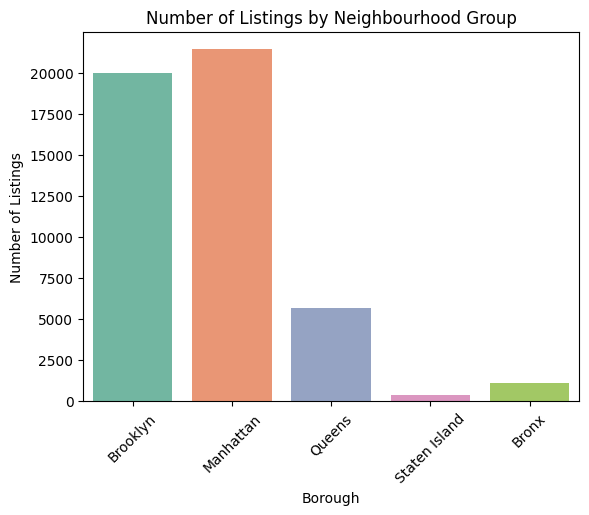

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='neighbourhood_group', palette='Set2')
plt.title("Number of Listings by Neighbourhood Group")
plt.xlabel("Borough")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.show()

Manhattan has the highest number of listings, followed by Brooklyn.

Staten Island has the least number of listings — which could indicate low demand or supply.

This shows how Airbnb activity is concentrated in Manhattan and Brooklyn, likely due to tourism, infrastructure, and accessibility.

C:\Users\kamal\AppData\Local\Temp\ipykernel_14612\3448576060.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='room_type', palette='pastel')


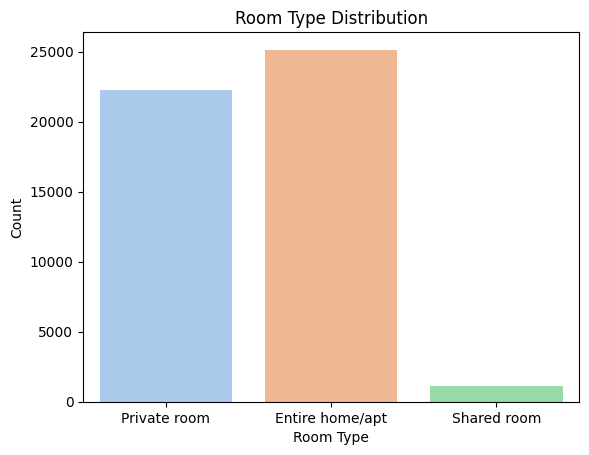

In [16]:
sns.countplot(data=df, x='room_type', palette='pastel')
plt.title("Room Type Distribution")
plt.xlabel("Room Type")
plt.ylabel("Count")
plt.show()


The most common listing type is Private Room, followed closely by Entire Home/Apt.

Shared Rooms are significantly fewer — likely due to privacy concerns in a major city.

This indicates Airbnb in NYC serves both budget travelers and long-stay tourists, but there's a preference toward more private accommodations.

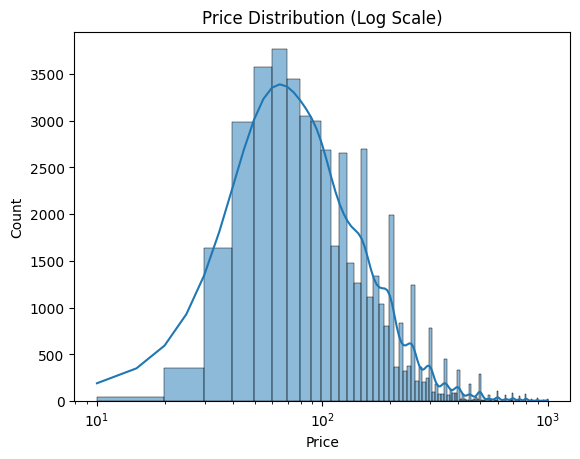

In [ ]:
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution (Log Scale)")
plt.xlabel("Price")
plt.xscale("log")
plt.show()


Most listings are priced between $50 and $200.

There’s a long tail of expensive listings, which were previously filtered to exclude extreme outliers.

The log-transformed plot provides a clearer view of how prices are distributed across typical budget ranges.

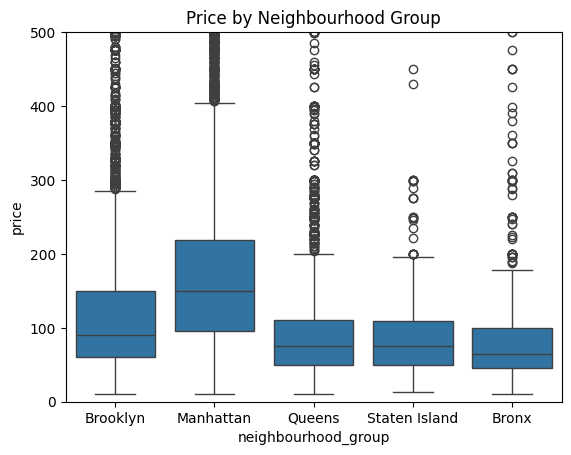

In [18]:
sns.boxplot(data=df, x='neighbourhood_group', y='price')
plt.title("Price by Neighbourhood Group")
plt.ylim(0, 500)  # Zoom in to typical range
plt.show()


Manhattan has the highest median price and widest spread.

Brooklyn follows, while Bronx and Queens have lower and more consistent pricing.

Staten Island listings are few but generally lower-priced.

This confirms that central boroughs are more expensive, likely due to tourism, business hubs, and proximity to landmarks.

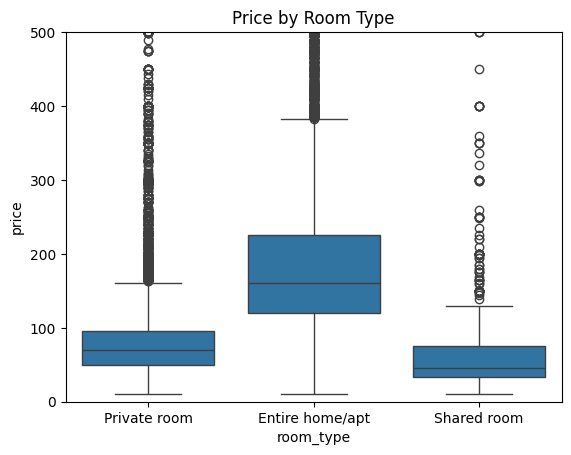

In [ ]:
sns.boxplot(data=df, x='room_type', y='price')
plt.title("Price by Room Type")
plt.ylim(0, 500)
plt.show()

Entire home/apt listings are clearly the most expensive on average.

Private rooms are significantly cheaper but show a wider price range (some luxury private rooms exist).

Shared rooms are the most affordable but also the least frequent.

The plot shows how room type directly influences price, and that more privacy comes at a premium.

In [25]:
import folium
from folium.plugins import MarkerCluster

sample_df = df.sample(1000, random_state=42)

m = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=11,
)

marker_cluster = MarkerCluster().add_to(m)

for _, row in sample_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['name']} (${row['price']})"
    ).add_to(marker_cluster)

m  # displays in notebook


Manhattan and Brooklyn appear densely populated with listings.

Fewer listings are found in Staten Island and the outer edges of Queens and Bronx.

This spatial insight confirms earlier bar charts and adds location-specific understanding of supply concentration.

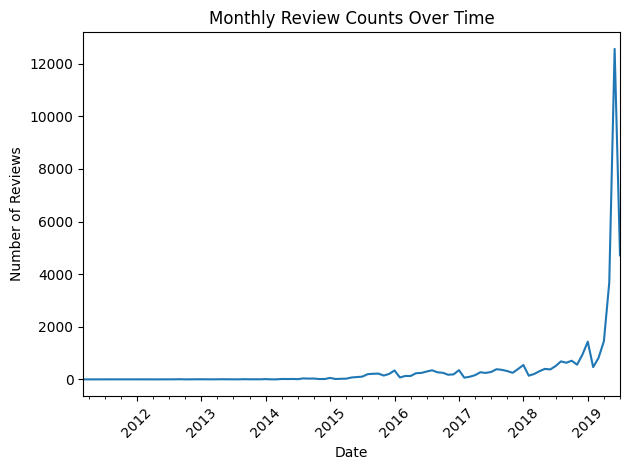

In [22]:
df['review_year_month'] = df['last_review'].dt.to_period('M')
monthly_reviews = df.groupby('review_year_month').size()

monthly_reviews.plot()
plt.title("Monthly Review Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The chart typically shows growth in review volume over time, indicating increasing Airbnb usage.

There may be seasonal dips or peaks, especially around holidays or tourism seasons.

Any sudden drops (e.g., after early 2020) could reflect real-world events like COVID-19 disruptions.

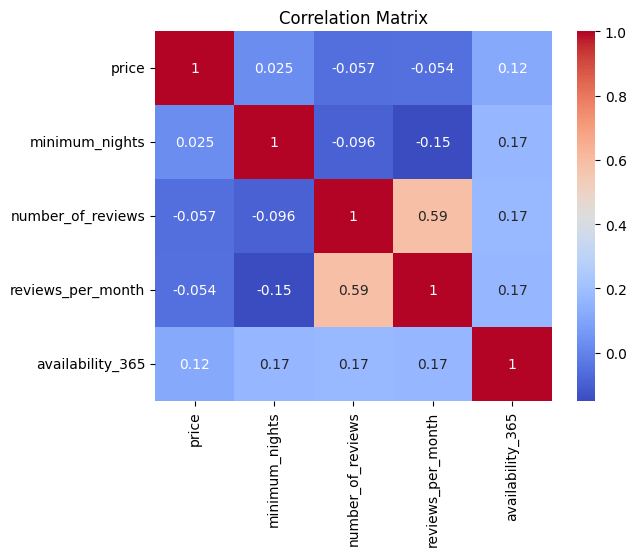

In [23]:
corr = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Most correlations are weak (close to 0):

price has no strong linear correlation with any variable here.

number_of_reviews and reviews_per_month are moderately correlated (~0.6), which is expected.

availability_365 has slight positive correlation with review frequency.

Overall, there are no strong dependencies, indicating features are mostly independent.

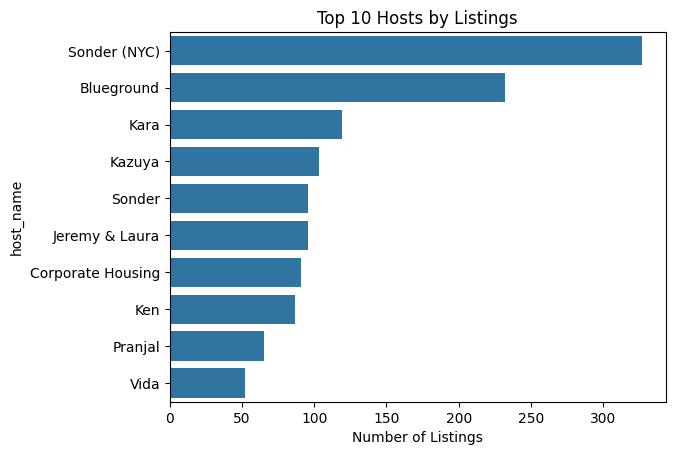

In [ ]:
top_hosts = df['host_id'].value_counts().head(10)
top_hosts_df = df[df['host_id'].isin(top_hosts.index)]

sns.countplot(data=top_hosts_df, y='host_name', order=top_hosts_df['host_name'].value_counts().index)
plt.title("Top 10 Hosts by Listings")
plt.xlabel("Number of Listings")
plt.show()

Some hosts manage dozens or even hundreds of listings, far beyond a typical individual host.

This suggests a commercial use of Airbnb in NYC, where a few hosts control a large share of the inventory.

Adds context to policy debates about Airbnb usage in urban residential areas.